In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.argv=['']
del sys
os.chdir("../")

In [2]:
import matplotlib.pyplot as plt
import os
import json
import math
import torch
import logging
import numpy as np
import pandas as pd

from IPython import embed
from common import data_preprocess 
from common.utils import print_to_json
from common.dataloader import load_SMAP_MSL_dataset, load_CSV_dataset, load_SMD_dataset
from common.sliding import BatchSlidingWindow, WindowIterator
from common.config import parse_arguments, set_logger, initialize_config
from networks.mlstm import MultiLSTMEncoder
from torch import nn
%matplotlib inline

In [3]:
# train
args = parse_arguments()

# load config
config_dir = "./hypers/" if not args["load"] else args["load"]
params = initialize_config(config_dir, args)
params["clear"] = 1
params["nrows"] = None

In [51]:
data_dict = load_SMD_dataset("./datasets/anomaly/SMD/processed", "machine-1-1")

2021-01-28 19:15:51,118 P61635 INFO Loading machine-1-1 dataset


1 files found.


In [52]:
pp = data_preprocess.preprocessor()
pp.save(params["save_path"])
data_dict = pp.normalize(data_dict,method="standard")
# data_dict = pp.discretize(data_dict,n_bins=100)
# vocab_size = pp.build_vocab(data_dict)

window_dict = data_preprocess.generate_windows(data_dict, data_hdf5_path=params["path"], **params)

2021-01-28 19:15:54,699 P61635 INFO Saving preprocessor into ./checkpoints/20210128-184820/preprocessor.pkl
2021-01-28 19:15:54,701 P61635 INFO Normalizing data
2021-01-28 19:15:54,702 P61635 INFO Generating sliding windows (size 32).
2021-01-28 19:15:54,808 P61635 INFO Train windows #: (889, 32, 38)
2021-01-28 19:15:54,809 P61635 INFO Test windows #: (28447, 32, 38)


In [53]:
window_dict["train_windows"].shape

(889, 32, 38)

In [55]:
train_iterator = WindowIterator(window_dict["train_windows"], batch_size=params["batch_size"], shuffle=True)
test_iterator = WindowIterator(window_dict["test_windows"], batch_size=params["batch_size"], shuffle=False)
params['in_channels'] = data_dict["dim"]

In [56]:
encoder = MultiLSTMEncoder(vocab_size=None, embedding_dim=None, **params)

2021-01-28 19:16:38,003 P61635 INFO Compiling finished.


In [57]:
# batch_window = next(iter(train_iterator.loader))
# print(batch_window.shape)
# batch_window = batch_window.permute(0, 2, 1)  # b x win x ts_dim
# batch_window, y = batch_window[:, 0:-1, :], batch_window[:, -1, :]

In [58]:
# training
encoder.fit(
            train_iterator,
            test_iterator=test_iterator.loader,
            test_labels=None,
            **params
        )
encoder.save_encoder()

2021-01-28 19:16:39,216 P61635 INFO Start training for 14 batches.
2021-01-28 19:16:42,107 P61635 INFO Epoch: 1, loss: 0.451
2021-01-28 19:16:44,973 P61635 INFO Epoch: 2, loss: 0.061
2021-01-28 19:16:47,824 P61635 INFO Epoch: 3, loss: 0.023
2021-01-28 19:16:50,652 P61635 INFO Epoch: 4, loss: 0.016
2021-01-28 19:16:53,501 P61635 INFO Epoch: 5, loss: 0.013
2021-01-28 19:16:56,350 P61635 INFO Epoch: 6, loss: 0.012
2021-01-28 19:16:59,193 P61635 INFO Epoch: 7, loss: 0.011
2021-01-28 19:17:02,028 P61635 INFO Epoch: 8, loss: 0.011
2021-01-28 19:17:04,853 P61635 INFO Epoch: 9, loss: 0.009
2021-01-28 19:17:07,707 P61635 INFO Epoch: 10, loss: 0.008
2021-01-28 19:17:10,529 P61635 INFO Epoch: 11, loss: 0.007
2021-01-28 19:17:13,373 P61635 INFO Epoch: 12, loss: 0.006
2021-01-28 19:17:16,218 P61635 INFO Epoch: 13, loss: 0.005
2021-01-28 19:17:19,090 P61635 INFO Epoch: 14, loss: 0.005
2021-01-28 19:17:21,935 P61635 INFO Epoch: 15, loss: 0.004
2021-01-28 19:17:25,016 P61635 INFO Epoch: 16, loss: 0.00

KeyboardInterrupt: 

In [59]:
encoder.save_encoder()

2021-01-28 19:17:56,455 P61635 INFO Saving model to ./checkpoints/20210128-184820/MultiLSTM_20210128-184820.pth


In [60]:
encoder.load_encoder()

2021-01-28 19:17:58,595 P61635 INFO Loading model from ./checkpoints/20210128-184820/MultiLSTM_20210128-184820.pth


In [61]:
# test_labels = window_dict["test_labels"][:, -1]
score_dict = encoder.score(test_iterator.loader, window_dict["test_labels"],)

2021-01-28 19:17:58,969 P61635 INFO Evaluating
2021-01-28 19:18:27,187 P61635 INFO AUC: 0.865, F1: 0.998, PS: 0.997, RC:0.998


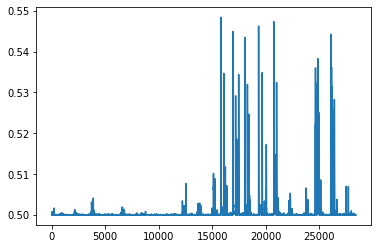

In [62]:
plt.plot(score_dict["score"])

In [63]:
# def reconstruction_loader(loader, encoder):
# train_iterator_non_shuffle = WindowIterator(window_dict["train_windows"],
#                                             batch_size=params["batch_size"], shuffle=False)
# loader = train_iterator_non_shuffle.loader

loader = test_iterator.loader
encoder = encoder.eval()
with torch.no_grad():
    recst_list = []
    real_list = []
    loss = 0
    for batch in loader:
        batch = batch.to(encoder.device)
        return_dict = encoder(batch)
        # diff = return_dict["diff"].max(dim=-1)[0] # chose the most anomaous ts
        recst = return_dict["recst"]  # chose the most anomaous ts
        recst_list.append(recst)
        real_list.append(return_dict["y"])
        loss += return_dict["loss"].item()
print(loss / len(loader))
recst_list = torch.cat(recst_list).cpu().numpy()
real_list = torch.cat(real_list).cpu().numpy()
diff_list = recst_list-real_list

0.002151899958682427


In [30]:
print(recst_list.shape)
print(real_list.shape)
print(diff_list.shape)

(28447, 1, 1)
(28447, 1, 1)
(28447, 1, 1)


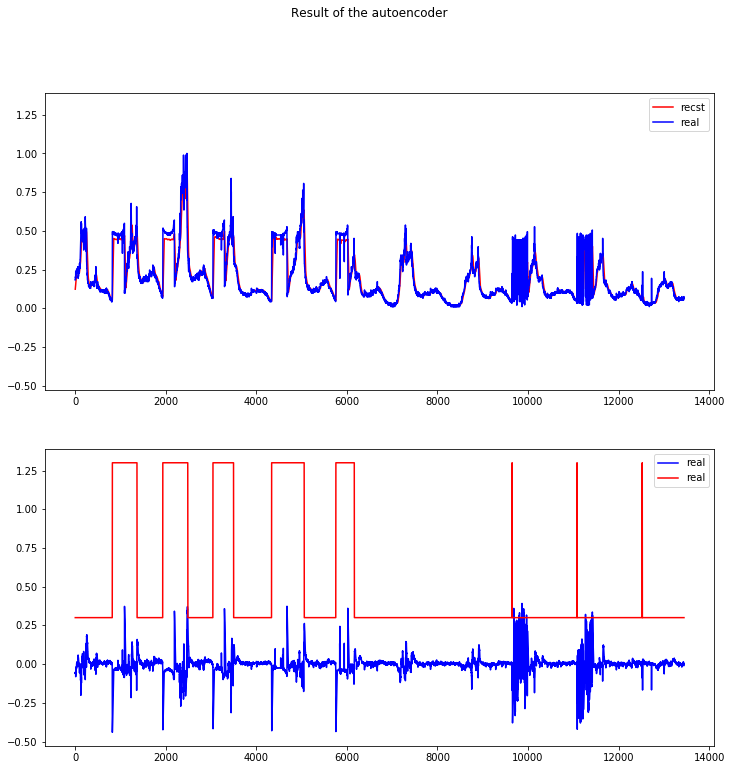

In [64]:
dims = [0,1]
fig, ax = plt.subplots(nrows=len(dims), sharey=True, figsize=(12,12))
# for i in range(len(dims)):
# ax[0].plot(recst, 'r', label='reconstruction')
# ax[0].legend(loc='best')
ax[0].plot(recst_list[15000:-1,i].reshape(-1), 'r', label='recst')
ax[0].plot(real_list[15000:-1,i].reshape(-1), 'b', label='real')
ax[1].plot(diff_list[15000:-1].reshape(-1), 'b', label='real')
ax[1].plot(window_dict["test_labels"][15000:, -1].reshape(-1)+0.3, 'r', label='real')
ax[0].legend(loc='best')
ax[1].legend(loc='best')

# ax[2].plot(recst, 'r', label='reconstruction')
# ax[2].plot(real, 'b', label='real')
# ax[2].legend(loc='best')

# ax[3].plot(diff, 'g', label='ecart')
# ax[3].legend(loc='best')

plt.legend()
plt.suptitle("Result of the autoencoder")
plt.show()